In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 44100

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 2.9442405700683594
(1506, 1, 88200)


In [12]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, c_targets, test_size=0.20, random_state=42)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 5s 2s/step - loss: 1458.7396
(1, 88200)


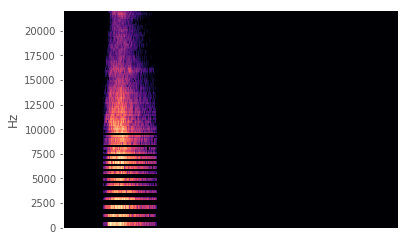

(1506, 128, 345)


In [14]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 88200),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [20]:
frames = mfccs

In [21]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(1506, 128, 345, 1)

In [22]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 345, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 337, 32)      2624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 19, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                77856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1650      
Total para

1023/1023 [==============================] - 6s 6ms/step - loss: 2.2923 - acc: 0.3402 - mean_absolute_error: 0.0708 - val_loss: 2.9269 - val_acc: 0.2265 - val_mean_absolute_error: 0.0671
Epoch 36/100
1023/1023 [==============================] - 6s 6ms/step - loss: 2.2135 - acc: 0.3392 - mean_absolute_error: 0.0646 - val_loss: 2.9863 - val_acc: 0.1878 - val_mean_absolute_error: 0.0647
Epoch 37/100
1023/1023 [==============================] - 6s 6ms/step - loss: 2.2386 - acc: 0.3470 - mean_absolute_error: 0.0665 - val_loss: 2.9376 - val_acc: 0.2210 - val_mean_absolute_error: 0.0653
Epoch 38/100
1023/1023 [==============================] - 6s 6ms/step - loss: 2.1828 - acc: 0.3656 - mean_absolute_error: 0.0619 - val_loss: 2.9552 - val_acc: 0.2431 - val_mean_absolute_error: 0.0588
Epoch 39/100
1023/1023 [==============================] - 6s 6ms/step - loss: 2.1322 - acc: 0.3812 - mean_absolute_error: 0.0576 - val_loss: 2.9550 - val_acc: 0.2376 - val_mean_absolute_error: 0.0561
Epoch 40/100


1023/1023 [==============================] - 7s 7ms/step - loss: 1.5682 - acc: 0.5269 - mean_absolute_error: 0.0303 - val_loss: 2.8759 - val_acc: 0.3204 - val_mean_absolute_error: 0.0288
Epoch 77/100
1023/1023 [==============================] - 7s 6ms/step - loss: 1.5617 - acc: 0.5376 - mean_absolute_error: 0.0297 - val_loss: 2.8185 - val_acc: 0.3149 - val_mean_absolute_error: 0.0305
Epoch 78/100
1023/1023 [==============================] - 6s 6ms/step - loss: 1.4977 - acc: 0.5572 - mean_absolute_error: 0.0298 - val_loss: 2.7345 - val_acc: 0.3260 - val_mean_absolute_error: 0.0298
Epoch 79/100
1023/1023 [==============================] - 7s 6ms/step - loss: 1.5516 - acc: 0.5474 - mean_absolute_error: 0.0300 - val_loss: 2.8752 - val_acc: 0.3315 - val_mean_absolute_error: 0.0290
Epoch 80/100
1023/1023 [==============================] - 6s 6ms/step - loss: 1.5581 - acc: 0.5337 - mean_absolute_error: 0.0300 - val_loss: 2.9417 - val_acc: 0.3039 - val_mean_absolute_error: 0.0305
Epoch 81/100


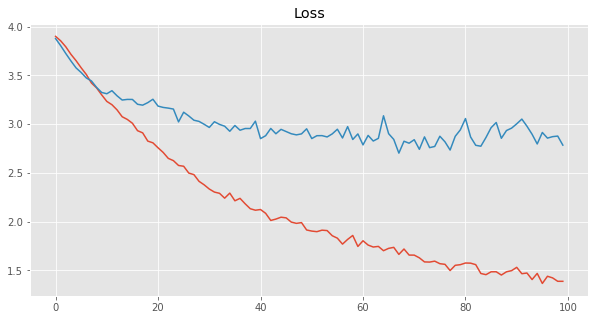

In [23]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.show()

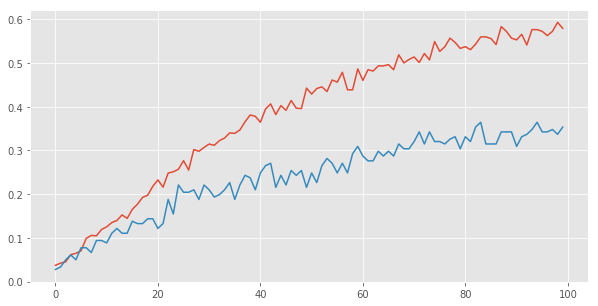

In [24]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.32450331125827814
Confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]


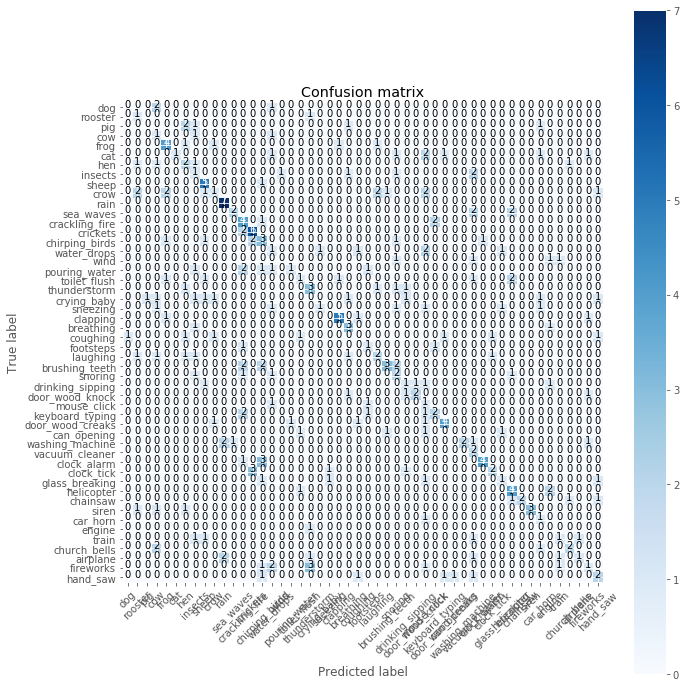

In [25]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

# All Data

In [26]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 3.090369462966919
	Processing Time: 3.1408867835998535
	Processing Time: 3.074178457260132
	Processing Time: 2.9112043380737305


In [27]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(6058, 1, 88200)


In [28]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(6058,)


In [29]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(6058,)


________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_4 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 166ms/step - loss: 1509.2537
(1, 88200)


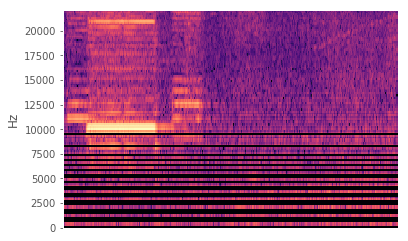

(6058, 128, 345)


In [30]:
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, X[1])
mfccs = evaluate_model(model, X)

0.20089138329481676
Confusion matrix, without normalization
[[15  1  1 ...  0  2  4]
 [ 0 37  1 ...  0  1  0]
 [ 0  1  9 ...  1  1 10]
 ...
 [ 0  1  0 ...  7  1  2]
 [ 0  0  0 ...  0 17  3]
 [ 0  0  9 ...  4  0 23]]


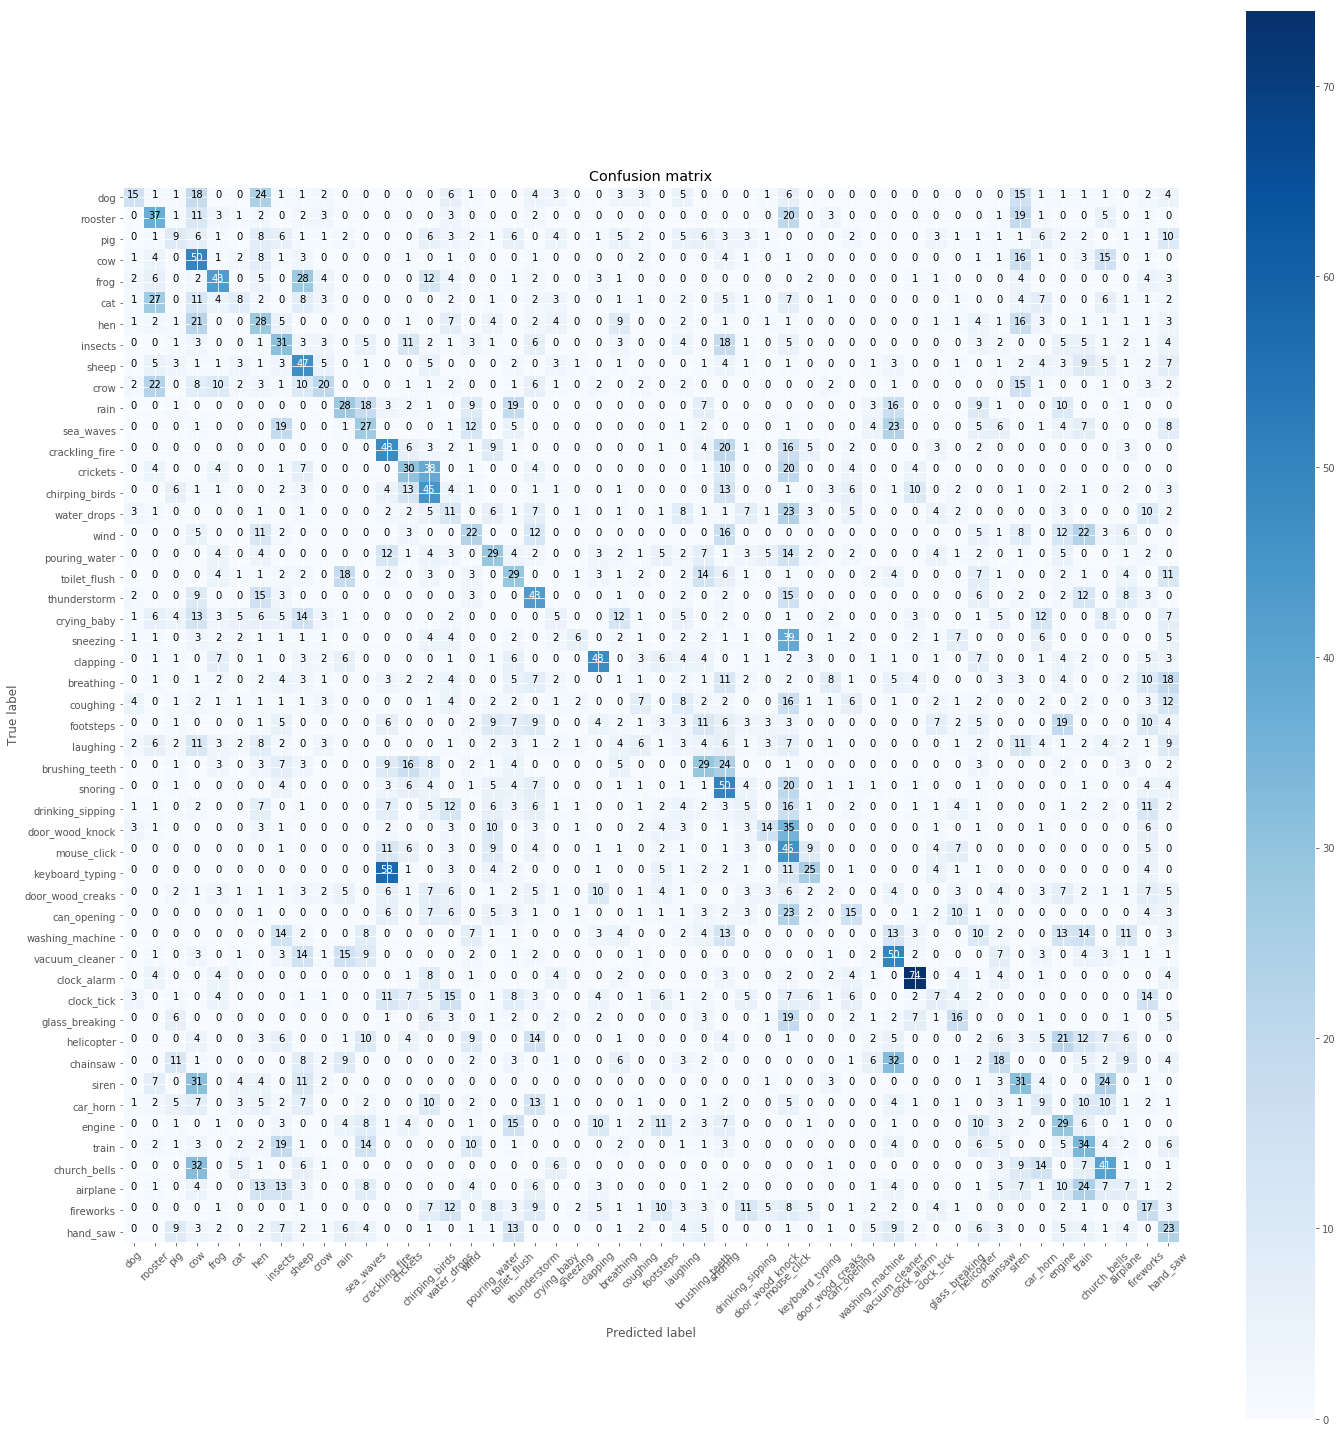

In [31]:
pred = clas.predict(X)
print(metrics.accuracy_score(yy, pred))
cm = metrics.confusion_matrix(yy, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()